# Part 2 - Data Preprocessing and Modeling

This notebook will focus on preprocessing data to bring them optimal size and format using data augmentation parameters. Once the preprocessing complete, I will train various Tensorflow Keras "sequential" and ""convolutional" networks as well as pre-trained models to sample transfer learning to come up with best results. As the classes are imbalanced, my success metrics should be Precision and Recall. Specifically Recall score is the most important as our goal is to focus on minimizing false negative rates to not classify a patient as healthy while in fact they have pneumonia.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from glob import glob

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

# For reproducibility
np.random.seed(42)

Using TensorFlow backend.


In [2]:
train_dir = './data/chest_xray/train/'
test_dir = './data/chest_xray/test/'

In [3]:
classes = ['bacterial', 'viral', 'normal']

I manually checked the images and found that there are a lot of variations for such a small dataset. The hight/width ratio, zooming range, angle of the body etc features differ among differen Xray images. Even the physical dimensions of images are vastly different. This makes it harder to train a model that will give high accuracy rate. I decided to use generator class to generate more images within train data with optimal rotation_range, shear_range, zoom_range, horizontal_flip (mirroring randomly selected images) to get additional observations to train the model with.

In [4]:
# Augmentation configuration to be used while training
train_generator = ImageDataGenerator(
                            rotation_range=20,
                            width_shift_range=0.25,
                            height_shift_range=0.25,
                            rescale=1./255,
                            shear_range=0.25,
                            zoom_range=0.25,
                            horizontal_flip=True,
                            fill_mode='nearest'
                            )

I will resize images to 224x224 px value and turn them to grayscale to only save the brightness and get rid of RGB values as the images are alrady provided as grayscale. It will help the train process run faster.


In [5]:
train_set = DirectoryIterator(train_dir,
                             train_generator,
                             target_size = (224, 224),
                             color_mode = 'rgb',
                             batch_size = 16,
                             classes=classes,
                             class_mode = 'categorical')

Found 5232 images belonging to 3 classes.


In [6]:
# Augmentation configuration to be used for validation
test_generator = ImageDataGenerator(rescale=1./255)

In [7]:
test_set = DirectoryIterator(test_dir,
                             test_generator,
                             target_size = (224, 224),
                             color_mode = 'rgb',
                             batch_size = 16, # set batch size a number that divides sample size
                             classes=classes,
                             class_mode = 'categorical')

Found 624 images belonging to 3 classes.


In [8]:
# Tensor size of train images
train_set.image_shape

(224, 224, 3)

In [9]:
# Tensor size of test images
test_set.image_shape

(224, 224, 3)

In [10]:
train_size = len(train_set.filenames)
test_size = len(test_set.filenames)

In [11]:
train_size, test_size

(5232, 624)

## Model #1 Dense

I will start with a simple sequential model and increase the complexity with based on the results we get from each iteration

In [12]:
# Initialize the sequential model
model1 = Sequential()

# Add flatten layer as input layer
model1.add(Flatten(input_shape = train_set.image_shape))

# Add a second densely-connected layer 
model1.add(Dense(units = 1024,
                activation='relu'))

# Add regularization
model1.add(Dropout(rate = 0.20))

# Add output layer
model1.add(Dense(units = 3,
    activation='softmax'
))

In [13]:
# Define optimizer
opt = SGD(lr=0.01)

In [14]:
# Compile the first model
model1.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [15]:
# Define early stopping
early_stopping_monitor = EarlyStopping(patience = 5, 
                                       monitor = "val_accuracy", 
                                       mode="max", 
                                       verbose = 2)

# Define batch size (a divisor of test sample size)
batch_size = 16

In [16]:
# Fit model on training data
history = model1.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs = 10,
#                               callbacks=[early_stopping_monitor],
                              steps_per_epoch = train_size/batch_size, 
                              validation_steps = test_size/batch_size,
                              shuffle=False,
                              verbose = 2)

Epoch 1/10
327/327 - 231s - loss: 8.2893 - accuracy: 0.4838 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 2/10
327/327 - 244s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 3/10
327/327 - 261s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 4/10
327/327 - 239s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 5/10
327/327 - 240s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 6/10
327/327 - 236s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 7/10
327/327 - 222s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 8/10
327/327 - 208s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 9/10
327/327 - 210s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 10/10
327/327 - 212s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - 

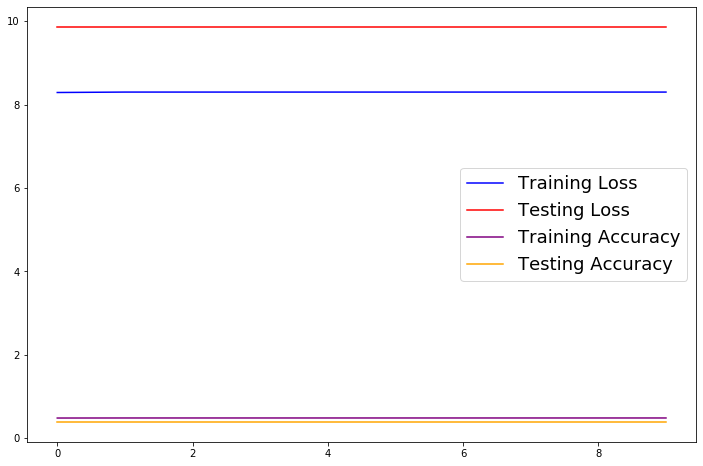

In [17]:
# Check out our train loss & accuracy and test loss & accuracy over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Generate line plot of training, testing loss & accuracy over epochs.
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')
plt.plot(train_accuracy, label='Training Accuracy', color='purple')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')
plt.legend(fontsize = 18);

In [18]:
predictions = model1.predict_generator(generator = test_set, 
                                       verbose = 2,
                                       steps = test_size/batch_size
                                      )

39/39 - 8s


In [19]:
y_hat = np.argmax(predictions, axis = 1) 
y_true = test_set.classes

In [20]:
len(y_true) == len(y_hat)

True

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

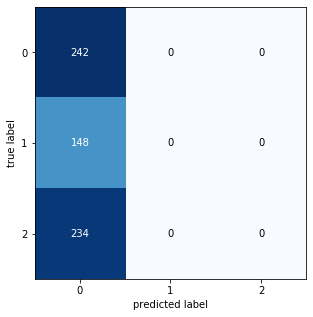

In [22]:
CM = confusion_matrix(y_true, y_hat)
fig, ax = plot_confusion_matrix(conf_mat=CM,  figsize=(5, 5))
plt.show()

My first model had five dense layers with very few neurons. It performed terrible with no predictive capability as all images were classified as bacterial pneumonia (majority class). I removed all additional dense layers and kept only one with large number of neurons which did not make any change. It seems like we can't get away without convolutional layers in such a large input size.

## Model #2 Simple CNN

In [28]:
# Initialize the sequential model
model2 = Sequential()

# Add convolution and pooling as input layer
model2.add(Conv2D(filters = 32, # number of filters
                 kernel_size = (3, 3), # height/width of filter
                 input_shape = train_set.image_shape, # shape of input (image)
                 activation = 'relu')) # activation function

model2.add(MaxPooling2D(pool_size = (2, 2))) # dimensions of region of pooling

# Add a second convolutional layer
model2.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3),
                 activation = 'relu'))

model2.add(MaxPooling2D(pool_size = (2, 2)))

# Add a flattening layer
model2.add(Flatten())

# Add a densely-connected layer
model2.add(Dense(units = 128,
                activation = 'relu'))

# Add output layer
model2.add(Dense(units = 3,
                activation = 'sigmoid'))

In [29]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               11944064  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [30]:
model2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [31]:
# Fit model on training data
history = model2.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs = 10,
                              callbacks=[early_stopping_monitor],
                              steps_per_epoch = train_size/batch_size, 
                              validation_steps = test_size/batch_size,
                              shuffle = True,
                              verbose = 2)

Epoch 1/10
327/327 - 262s - loss: 0.5500 - accuracy: 0.7427 - val_loss: 0.6414 - val_accuracy: 0.7158
Epoch 2/10
327/327 - 287s - loss: 0.4778 - accuracy: 0.7791 - val_loss: 0.5886 - val_accuracy: 0.7580
Epoch 3/10
327/327 - 276s - loss: 0.4750 - accuracy: 0.7819 - val_loss: 0.5115 - val_accuracy: 0.7724
Epoch 4/10
327/327 - 283s - loss: 0.4617 - accuracy: 0.7892 - val_loss: 0.4703 - val_accuracy: 0.7965
Epoch 5/10
327/327 - 286s - loss: 0.4452 - accuracy: 0.7961 - val_loss: 0.5571 - val_accuracy: 0.7553
Epoch 6/10
327/327 - 287s - loss: 0.4374 - accuracy: 0.8010 - val_loss: 0.5285 - val_accuracy: 0.7853
Epoch 7/10
327/327 - 296s - loss: 0.4263 - accuracy: 0.8078 - val_loss: 0.4447 - val_accuracy: 0.8136
Epoch 8/10
327/327 - 294s - loss: 0.4330 - accuracy: 0.8038 - val_loss: 0.4449 - val_accuracy: 0.8189
Epoch 9/10
327/327 - 298s - loss: 0.4210 - accuracy: 0.8078 - val_loss: 0.4221 - val_accuracy: 0.8285
Epoch 10/10
327/327 - 390s - loss: 0.4105 - accuracy: 0.8120 - val_loss: 0.4033 - 

## Model #3 - Pre-trained Model (VGG16 Convolutional Base)

I decided to use the artichecture of a pre-trained model as I was curious about transfer learning outcome. Transfer learning is using a pre-trained model and/or its weights on a different dataset. I chose to use the arthitecture of VGG16 convolutional neural network which is popular from ImageNet competition. This allowed me to save time for inital checking the capability of my data without requiring vast amount of hyperparameter tunning and optimizing.

In [ ]:
# base_model = VGG16(weights = 'imagenet', 
#                  include_top = False,
#                  input_shape = train_set.image_shape)

In [ ]:
# VGG16 Arthitecture

model = Sequential()
model.add(Conv2D(input_shape=train_set.image_shape, filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="sigmoid"))

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
checkpoint = ModelCheckpoint("vgg16.h5", monitor='accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
history = model.fit_generator(steps_per_epoch=100,
                              generator=train_set, 
                              validation_data=test_set, 
                              validation_steps=10,
                              epochs=25,
                              callbacks=[checkpoint,early])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()